##Natural Language Processing With Disaster Tweets
Using NLP to classify whether tweets about natural disasters are serious or not.

Not every tweet that mentions “fire,” “flood,” or similar terms is actually reporting a real disaster. The goal is to build a model that reads a tweet and decides whether it’s describing a genuine disaster or not. Using NLP to transform tweets into numeric features and train a classifier model.

In [4]:
#Import libraries
import pandas as pd
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


In [5]:
#turn csv files to dataframes
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

##Data Description and Inspection
Data is sourced from Kaggle. See below for data descriptions.

In [6]:
print(train_df.info(), '\n')
print(test_df.info(), '\n')

print('Percent of train null values:', '\n', (train_df.isna().mean() * 100).round(2), '\n')
print('Percent of test null values:', '\n', (test_df.isna().mean() * 100).round(2), '\n')

print('Number of training unique values:', '\n', train_df.nunique(dropna=True), '\n')
print('Number of testing unique values:', '\n', test_df.nunique(dropna=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None 

Percent of train null values: 
 id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64 

Percent of test null values: 
 id    

In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis (EDA)

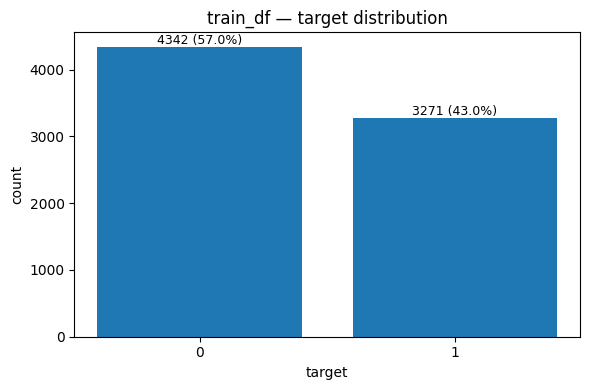

In [9]:
#Target Distribution
counts = train_df["target"].value_counts(dropna=False).sort_index()
pcts = counts / counts.sum() * 100

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("train_df — target distribution")
plt.xlabel("target")
plt.ylabel("count")
for i, (c, p) in enumerate(zip(counts.values, pcts.values)):
    plt.text(i, c, f"{int(c)} ({p:.1f}%)", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

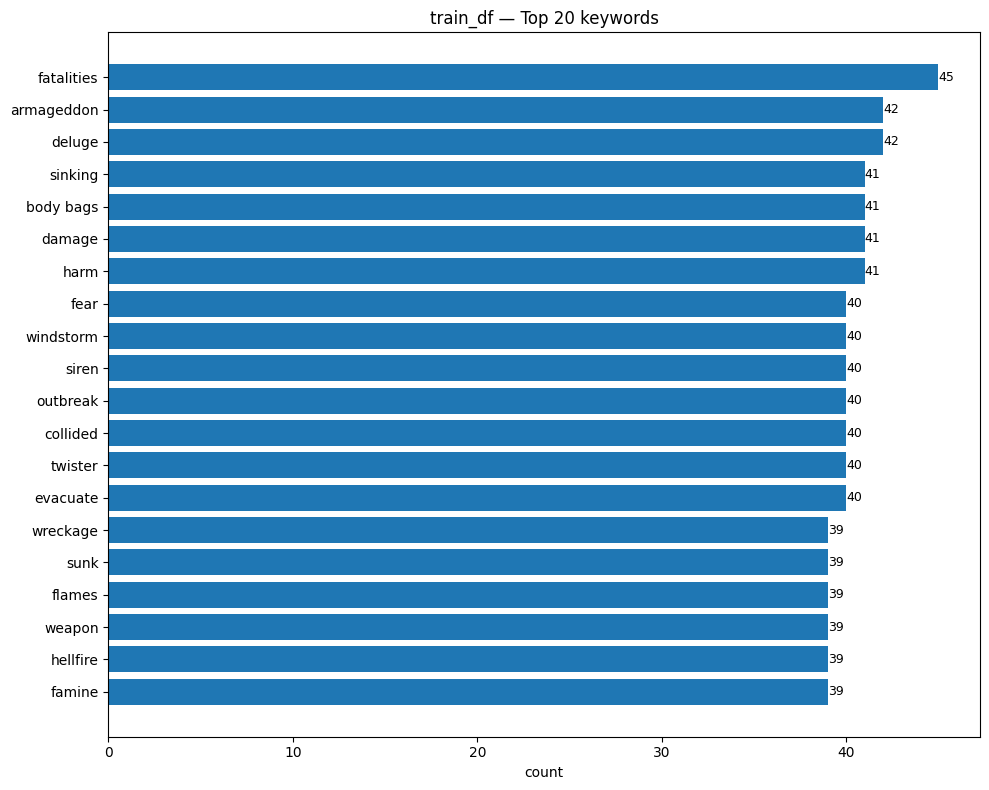

In [10]:
# Top 20 Keywords
kw = (train_df["keyword"]
      .astype("string")
      .str.replace("%20", " ", regex=False)
      .str.replace("_", " ", regex=False)
      .str.strip()
      .str.lower())

vc = kw.value_counts().head(20).sort_values(ascending=True)

plt.figure(figsize=(10, max(4, 0.4 * len(vc))))
plt.barh(vc.index, vc.values)
plt.title("train_df — Top 20 keywords")
plt.xlabel("count")
for i, v in enumerate(vc.values):
    plt.text(v, i, str(v), va="center", ha="left", fontsize=9)
plt.tight_layout()
plt.show()


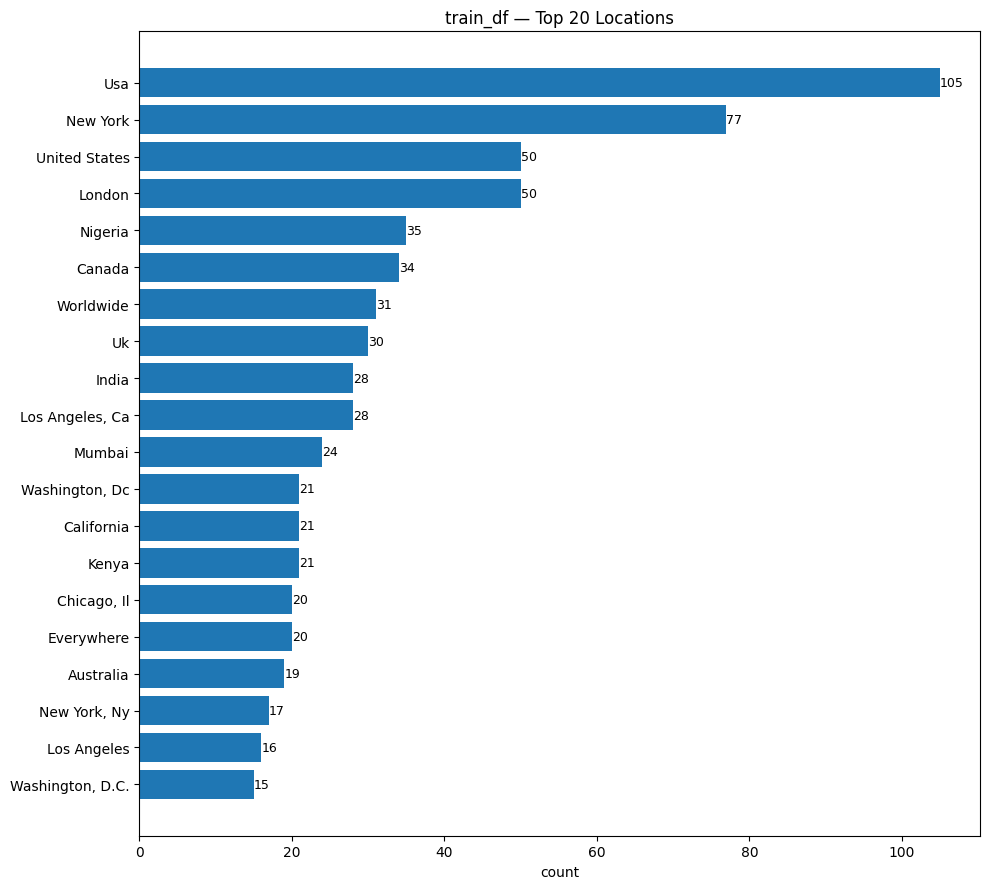

In [11]:
# Top 20 Locations
loc = (train_df["location"]
       .astype("string")
       .str.strip()
       .str.replace(r"\s+", " ", regex=True)
       .str.lower())

vc = loc.value_counts().head(20).sort_values(ascending=True)
labels = vc.index.to_series().str.title()

plt.figure(figsize=(10, max(4, 0.45 * len(vc))))
plt.barh(labels, vc.values)
plt.title("train_df — Top 20 Locations")
plt.xlabel("count")
for y, v in enumerate(vc.values):
    plt.text(v, y, str(v), va="center", ha="left", fontsize=9)
plt.tight_layout()
plt.show()


In [12]:
#Text Diagnostics
def text_diagnostics(df, text_col="text"):
    if text_col not in df.columns:
        return pd.DataFrame({"note": [f"'{text_col}' not in df"]})
    s = df[text_col].astype(str)
    stats = pd.DataFrame({
        "len_char_min": [s.str.len().min()],
        "len_char_mean": [s.str.len().mean()],
        "len_char_median": [s.str.len().median()],
        "len_char_max": [s.str.len().max()],
        "empty_or_whitespace_%": [(s.str.strip().eq("").mean() * 100).round(2)],
        "has_url_%": [(s.str.contains(r"http[s]?://", regex=True, na=False).mean() * 100).round(2)],
        "has_mention_%": [(s.str.contains(r"@\w+", regex=True, na=False).mean() * 100).round(2)],
        "has_hashtag_%": [(s.str.contains(r"#\w+", regex=True, na=False).mean() * 100).round(2)],
        "non_ascii_%": [((~s.apply(lambda x: x.isascii())).mean() * 100).round(2)],
    })
    return stats
display(text_diagnostics(train_df, "text"))
display(text_diagnostics(test_df, "text"))

,len_char_min,len_char_mean,len_char_median,len_char_max,empty_or_whitespace_%,has_url_%,has_mention_%,has_hashtag_%,non_ascii_%
0,7,101.037436,107.0,157,0.0,52.16,26.39,22.9,9.16


,len_char_min,len_char_mean,len_char_median,len_char_max,empty_or_whitespace_%,has_url_%,has_mention_%,has_hashtag_%,non_ascii_%
0,5,102.108183,109.0,151,0.0,53.05,28.13,24.55,10.14


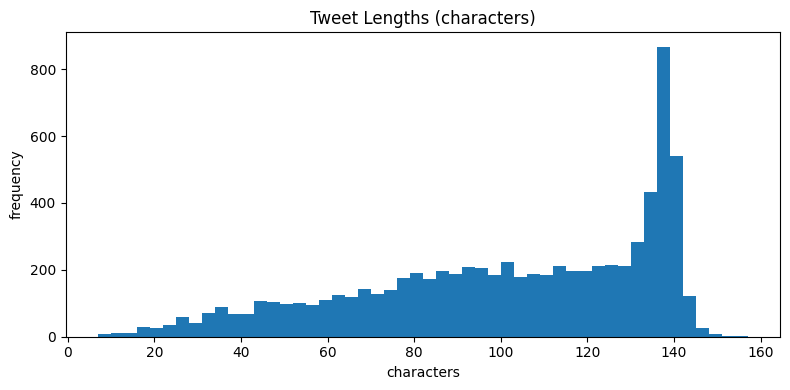

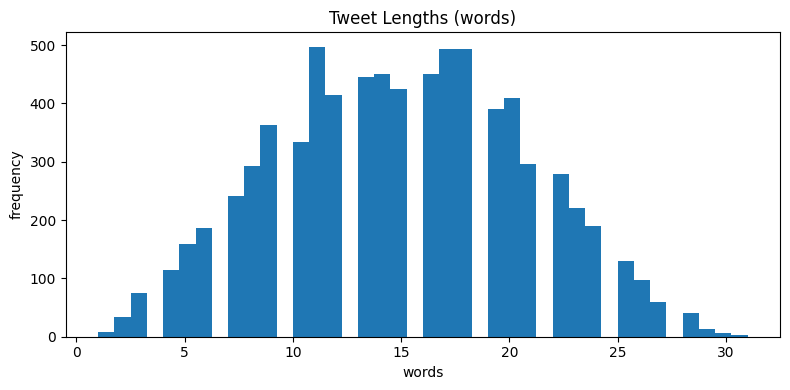

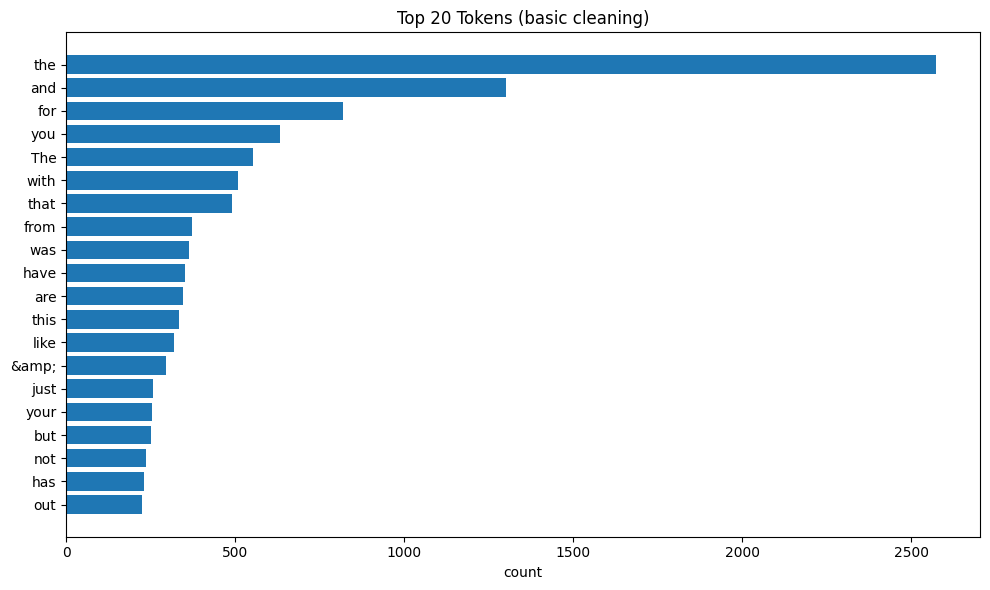

In [13]:
#Text
char_len = train_df["text"].astype(str).str.len()

plt.figure(figsize=(8, 4))
plt.hist(char_len, bins=50)
plt.title("Tweet Lengths (characters)")
plt.xlabel("characters")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

word_len = train_df["text"].astype(str).str.split().str.len()

plt.figure(figsize=(8, 4))
plt.hist(word_len, bins=40)
plt.title("Tweet Lengths (words)")
plt.xlabel("words")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

tokens = []
for t in train_df["text"]:
    tokens.extend([w for w in t.split() if len(w) > 2])

top20 = Counter(tokens).most_common(20)
words, counts = zip(*top20) if top20 else ([], [])

plt.figure(figsize=(10, 6))
plt.barh(words[::-1], counts[::-1])
plt.title("Top 20 Tokens (basic cleaning)")
plt.xlabel("count")
plt.tight_layout()
plt.show()


##EDA Findings
The dataset has cleaner text fields but sparse, messy metadata: `keyword` needs normalization and `location` shows high cardinality with many nulls, so treat it as a weak, optional feature. The target is moderately imbalanced toward non-disaster, and there are some duplicate tweets to deduplicate. Train and test text seem distributionally similar.

##Cleaning/Normalizing Data
Next is to standardize text (lowercase, strip URLs/handles/extra punctuation, careful stopwording), normalize `keyword`, add missingness flags, and add lightweight signals (lengths, counts, hashtag/URL/mention indicators) and TF-IDF word/char n-grams.

In [14]:
train = train_df.copy()
test  = test_df.copy()

# Drop exact duplicate tweets
train = train.drop_duplicates(subset=["text", "target"]).reset_index(drop=True)

# Normalize keyword and add missingness flags
for df in (train, test):
    df["keyword_clean"] = (df["keyword"].astype("string")
                           .str.replace("%20", " ", regex=False)
                           .str.replace("_", " ", regex=False)
                           .str.strip()
                           .str.lower())
    df["keyword_missing"] = df["keyword_clean"].isna()

# Normalize location + missing flags
for df in (train, test):
    df["location_clean"] = (df["location"].astype("string")
                            .str.strip()
                            .str.replace(r"\s+", " ", regex=True)
                            .str.lower()
                            .str.replace(r"[^\w\s,.\-]", "", regex=True))  # drop emojis/symbols
    df["location_missing"] = df["location_clean"].isna()

# Text cleaning
url_pat      = re.compile(r"http\S+")
mention_pat  = re.compile(r"@\w+")
hashtag_pat  = re.compile(r"#(\w+)")
multi_space  = re.compile(r"\s+")
non_keep_pat = re.compile(r"[^a-z0-9'\s]")

for df in (train, test):
    s = df["text"].astype("string")

    df["has_url"]     = s.str.contains(r"http[s]?://", regex=True, na=False).astype(int)
    df["has_mention"] = s.str.contains(r"@\w+",        regex=True, na=False).astype(int)
    df["has_hashtag"] = s.str.contains(r"#\w+",        regex=True, na=False).astype(int)

    s = s.apply(lambda x: unicodedata.normalize("NFKC", x))
    s = s.str.replace(url_pat, " ", regex=True)
    s = s.str.replace(mention_pat, " ", regex=True)
    s = s.str.replace(hashtag_pat, r"\1", regex=True)
    s = s.str.replace("&amp;", " and ", regex=False)
    s = s.str.lower()
    s = s.str.replace(non_keep_pat, " ", regex=True)
    s = s.str.replace(multi_space, " ", regex=True).str.strip()

    df["text_clean"] = s
    df["text_len_char"] = df["text_clean"].str.len()
    df["text_len_word"] = df["text_clean"].str.split().str.len()

# Stopword removal and extra column
extra_stops = {
    "im","ive","id","youre","weve","theyre","dont","doesnt","didnt","cant","couldnt",
    "shouldnt","wont","wouldnt","rt","via","amp","u","ur","ya","ok","okay","lol","omg"
}
stop = set(ENGLISH_STOP_WORDS) | extra_stops

for df in (train, test):
    df["text_clean_nostop"] = df["text_clean"].apply(
        lambda s: " ".join(w for w in s.split() if w not in stop)
    )

train_clean = train
test_clean  = test

In [15]:
train_clean.head()

,id,keyword,location,text,target,keyword_clean,keyword_missing,location_clean,location_missing,has_url,has_mention,has_hashtag,text_clean,text_len_char,text_len_word,text_clean_nostop
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,<NA>,True,<NA>,True,0,0,1,our deeds are the reason of this earthquake ma...,68,13,deeds reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,<NA>,True,<NA>,True,0,0,0,forest fire near la ronge sask canada,37,7,forest near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,<NA>,True,<NA>,True,0,0,0,all residents asked to 'shelter in place' are ...,132,22,residents asked 'shelter place' notified offic...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,<NA>,True,<NA>,True,0,0,1,13 000 people receive wildfires evacuation ord...,63,9,13 000 people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,<NA>,True,<NA>,True,0,0,1,just got sent this photo from ruby alaska as s...,85,16,just got sent photo ruby alaska smoke wildfire...


##NLP Model
The task is treated as supervised text classification. Text is cleaned by fixing odd characters, removing URLs and @mentions, converting hashtags to words, lowercasing, removing junk characters, and trimming extra spaces. Two text versions are maintained—one with stop words and one without—to compare performance. Simple signals are added (presence of URL/mention/hashtag and basic length counts). Metadata is standardized: keyword is normalized, location is retained cautiously due to noise, and missingness flags are included. Features use TF-IDF word n-grams (1–2 or 1–3), optional character n-grams (3–5), and a separate TF-IDF over keyword; numeric features are MaxAbs-scaled to fit sparse matrices. Models include Logistic Regression and Linear SVM with class balancing. Evaluation uses stratified K-fold cross-validation with F1. A small grid search tunes the regularization C and the relative weights of each feature stream.

In [16]:
RANDOM_STATE = 42

#Target
y = train_clean["target"].astype(int).values
test_ids = test_clean["id"].values

#Features
text_col = "text_clean"
kw_col   = "keyword_clean"
num_cols = ["has_url","has_mention","has_hashtag","text_len_char","text_len_word",
            "keyword_missing","location_missing"]

# Feature processing
txt_tfidf = Pipeline([
    ("fill", FunctionTransformer(lambda s: s.fillna(""), validate=False)),
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, lowercase=False,
                              token_pattern=r"(?u)\b\w+\b", max_features=120_000))
])

kw_tfidf = Pipeline([
    ("fill", FunctionTransformer(lambda s: s.fillna(""), validate=False)),
    ("tfidf", TfidfVectorizer(ngram_range=(1,1), lowercase=False))
])

feats = ColumnTransformer(
    transformers=[
        ("txt", txt_tfidf, text_col),
        ("kw",  kw_tfidf,  kw_col),
        ("num", MaxAbsScaler(), num_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

In [17]:
# Logistic Regression baseline
lr_pipe = Pipeline([
    ("feats", feats),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", C=2.0))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
lr_cv = cross_val_score(lr_pipe, train_clean, y, cv=cv, scoring="f1", n_jobs=-1)
print(f"LogReg 5-fold F1: mean={lr_cv.mean():.4f}  std={lr_cv.std():.4f}")

# Fit on train
lr_pipe.fit(train_clean, y)
test_pred_lr = lr_pipe.predict(test_clean)

sub_lr = pd.DataFrame({"id": test_ids, "target": test_pred_lr.astype(int)})

LogReg 5-fold F1: mean=0.7581  std=0.0135


In [18]:
# Linear SVM variant
svc_pipe = Pipeline([
    ("feats", feats),
    ("clf", LinearSVC(C=0.75, class_weight="balanced", random_state=RANDOM_STATE))
])

svc_cv = cross_val_score(svc_pipe, train_clean, y, cv=cv, scoring="f1", n_jobs=-1)
print(f"LinearSVC 5-fold F1: mean={svc_cv.mean():.4f}  std={svc_cv.std():.4f}")

svc_pipe.fit(train_clean, y)
test_pred_svc = svc_pipe.predict(test_clean)

sub_svc = pd.DataFrame({"id": test_ids, "target": test_pred_svc.astype(int)})

LinearSVC 5-fold F1: mean=0.7447  std=0.0139


##Hyperparameter Tuning

In [19]:
RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
f1_scorer = make_scorer(f1_score)

In [20]:
# Text & keyword transformers
txt_word = Pipeline([
    ("fill", FunctionTransformer(lambda s: s.fillna(""), validate=False)),
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2,
        lowercase=False,
        token_pattern=r"(?u)\b\w+\b",
        max_features=80_000
    ))
])

txt_word_ns = Pipeline([
    ("fill", FunctionTransformer(lambda s: s.fillna(""), validate=False)),
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2,
        lowercase=False,
        token_pattern=r"(?u)\b\w+\b",
        max_features=80_000
    ))
])

txt_char = Pipeline([
    ("fill", FunctionTransformer(lambda s: s.fillna(""), validate=False)),
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(3,5),
        min_df=2,
        lowercase=False
    ))
])

kw_tfidf = Pipeline([
    ("fill", FunctionTransformer(lambda s: s.fillna(""), validate=False)),
    ("tfidf", TfidfVectorizer(ngram_range=(1,1), lowercase=False))
])

# ColumnTransformer
feats = ColumnTransformer(
    transformers=[
        ("txt_word",    txt_word,    "text_clean"),
        ("txt_word_ns", txt_word_ns, "text_clean_nostop"),
        ("txt_char",    txt_char,    "text_clean"),
        ("kw",          kw_tfidf,    "keyword_clean"),
        ("num",         MaxAbsScaler(), num_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

In [21]:
#Base Pipelines
lr_pipe = Pipeline([
    ("feats", feats),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", C=1.0))
])

svc_pipe = Pipeline([
    ("feats", feats),
    ("clf", LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM_STATE))
])

# Weight/Grid Options
weight_values = [
    {"txt_word":1.0, "txt_word_ns":0.0, "txt_char":0.0, "kw":1.0, "num":1.0},  # word only
    {"txt_word":0.0, "txt_word_ns":1.0, "txt_char":0.0, "kw":1.0, "num":1.0},  # nostop only
    {"txt_word":0.0, "txt_word_ns":1.0, "txt_char":0.0, "kw":1.0, "num":1.0},
]

common_grid = {
    "feats__transformer_weights": weight_values,
    "feats__txt_word__tfidf__ngram_range": [(1,2), (1,3)],
    "feats__txt_word__tfidf__min_df": [2],
}

lr_grid  = [dict(common_grid, **{"clf__C": [0.5, 1.0]})]
svc_grid = [dict(common_grid, **{"clf__C": [0.5, 1.0]})]

In [22]:
lr_search = GridSearchCV(lr_pipe, lr_grid, scoring=f1_scorer, cv=cv, n_jobs=-1, verbose=1)
lr_search.fit(train_clean, train_clean["target"].astype(int).values)
print(f"[LR] Best F1: {lr_search.best_score_:.4f} | params: {lr_search.best_params_}")

svc_search = GridSearchCV(svc_pipe, svc_grid, scoring=f1_scorer, cv=cv, n_jobs=-1, verbose=1)
svc_search.fit(train_clean, train_clean["target"].astype(int).values)
print(f"[SVC] Best F1: {svc_search.best_score_:.4f} | params: {svc_search.best_params_}")

if lr_search.best_score_ >= svc_search.best_score_:
    best_est, best_name, best_cv = lr_search.best_estimator_, "lr", lr_search.best_score_
else:
    best_est, best_name, best_cv = svc_search.best_estimator_, "svc", svc_search.best_score_

print(f"\nSelected {best_name.upper()} (CV F1={best_cv:.4f})")
best_est.fit(train_clean, train_clean["target"].astype(int).values)

test_pred = best_est.predict(test_clean).astype(int)
sub = pd.DataFrame({"id": test_clean["id"].values, "target": test_pred})

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LR] Best F1: 0.7556 | params: {'clf__C': 1.0, 'feats__transformer_weights': {'txt_word': 0.0, 'txt_word_ns': 1.0, 'txt_char': 0.0, 'kw': 1.0, 'num': 1.0}, 'feats__txt_word__tfidf__min_df': 2, 'feats__txt_word__tfidf__ngram_range': (1, 2)}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[SVC] Best F1: 0.7504 | params: {'clf__C': 0.5, 'feats__transformer_weights': {'txt_word': 1.0, 'txt_word_ns': 0.0, 'txt_char': 0.0, 'kw': 1.0, 'num': 1.0}, 'feats__txt_word__tfidf__min_df': 2, 'feats__txt_word__tfidf__ngram_range': (1, 2)}

Selected LR (CV F1=0.7556)


##Results

In [23]:
# Best Fit
if lr_search.best_score_ >= svc_search.best_score_:
    best_est = lr_search.best_estimator_
    best_name = "lr"
    best_cv = lr_search.best_score_
else:
    best_est = svc_search.best_estimator_
    best_name = "svc"
    best_cv = svc_search.best_score_

print(f"Selected model: {best_name.upper()} (CV F1={best_cv:.4f})")
best_est.fit(train_clean, y)


Selected model: LR (CV F1=0.7556)


Pipeline(steps=[('feats',
                 ColumnTransformer(transformer_weights={'kw': 1.0, 'num': 1.0,
                                                        'txt_char': 0.0,
                                                        'txt_word': 0.0,
                                                        'txt_word_ns': 1.0},
                                   transformers=[('txt_word',
                                                  Pipeline(steps=[('fill',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7a6c3ca89bc0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(lowercase=False,
                                                                                   max_features=80000,
                                                                                   min_df=2,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   token_pattern='(?u)...
                                                  Pipeline(steps=[('fill',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7a6c3ca92340>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(lowercase=False))]),
                                                  'keyword_clean'),
                                                 ('num', MaxAbsScaler(),
                                                  ['has_url', 'has_mention',
                                                   'has_hashtag',
                                                   'text_len_char',
                                                   'text_len_word',
                                                   'keyword_missing',
                                                   'location_missing'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

##Conclusion
After cleaning, feature building, and tuning, Logistic Regression performs best: 5-fold CV F1 = 0.758, slightly above LinearSVC = 0.745. The strongest setup uses C = 1.0 and places more weight on the no-stopword text, while character n-grams and the with-stopwords stream contribute less. Most helpful elements include solid text cleaning, a dedicated TF-IDF over keyword, a few simple numeric flags, class balancing, and tuning C for F1. Key limitation: location remains noisy. Suggested next steps: threshold tuning with calibrated probabilities, adding compact transformer embeddings or fine-tuning a small model with strong regularization, targeted error analysis for figurative “fire/flood” language, and a lightweight ensemble. Overall, a clean TF-IDF + Logistic Regression pipeline offers a strong, interpretable baseline.